In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from return_cov import f_return_cov

%matplotlib inline
pd.options.mode.chained_assignment = None

In [ ]:
expected_value, cov_matrix = f_return_cov()

In [3]:
# Define the objective function to be optimized
q = 0.5 
B  = 2 
lamb= 1
depth = 9
def objective(params):
    gamma = params[:depth]
    beta = params[depth:]
    qaoa = QAOA(expected_value, cov_matrix, q, B, lamb)
    for i in range(depth):
        qaoa.add_layer(gamma[i], beta[i])

    energy, _ = qaoa.measure_energy()
    return energy

# Specify the initial parameters for optimization.
vec_gamma = []
vec_beta = []
initial_params = []
for _ in range(depth):
    gamma = np.random.uniform(0, 2*np.pi)
    beta = np.random.uniform(0, 2*np.pi)
    vec_gamma.append(gamma)
    vec_beta.append(beta)
    initial_params.append(gamma)
    initial_params.append(beta)

## Global optimal solution

In [4]:
from ai_quantum.utils.cost_function import sort_by_cost_function
sort_by_cost_function(expected_value, cov_matrix, q, lamb, B)

,solution,cost_function
10,"(1, 0, 1, 0)",-0.367542
3,"(0, 0, 1, 1)",-0.304843
9,"(1, 0, 0, 1)",-0.247483
6,"(0, 1, 1, 0)",-0.219767
12,"(1, 1, 0, 0)",-0.164171
5,"(0, 1, 0, 1)",-0.103236
11,"(1, 0, 1, 1)",0.623730
14,"(1, 1, 1, 0)",0.725690
7,"(0, 1, 1, 1)",0.744793
2,"(0, 0, 1, 0)",0.751765


## --------

In [5]:
result = minimize(objective, initial_params, method='COBYLA')

gamma = result.x[:depth]
beta = result.x[depth:]

In [6]:
# Generate the optimal circuit.
qaoa = QAOA(expected_value, cov_matrix, q, B, lamb)
for i in range(depth):
    qaoa.add_layer(gamma[i], beta[i])
    
energy, counts = qaoa.measure_energy()
energy

np.float64(-3.130828375)

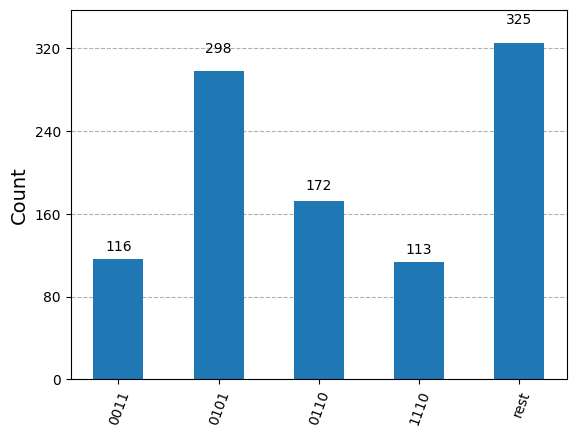

In [7]:
plot_histogram(counts, number_to_keep=4)
plt.show()

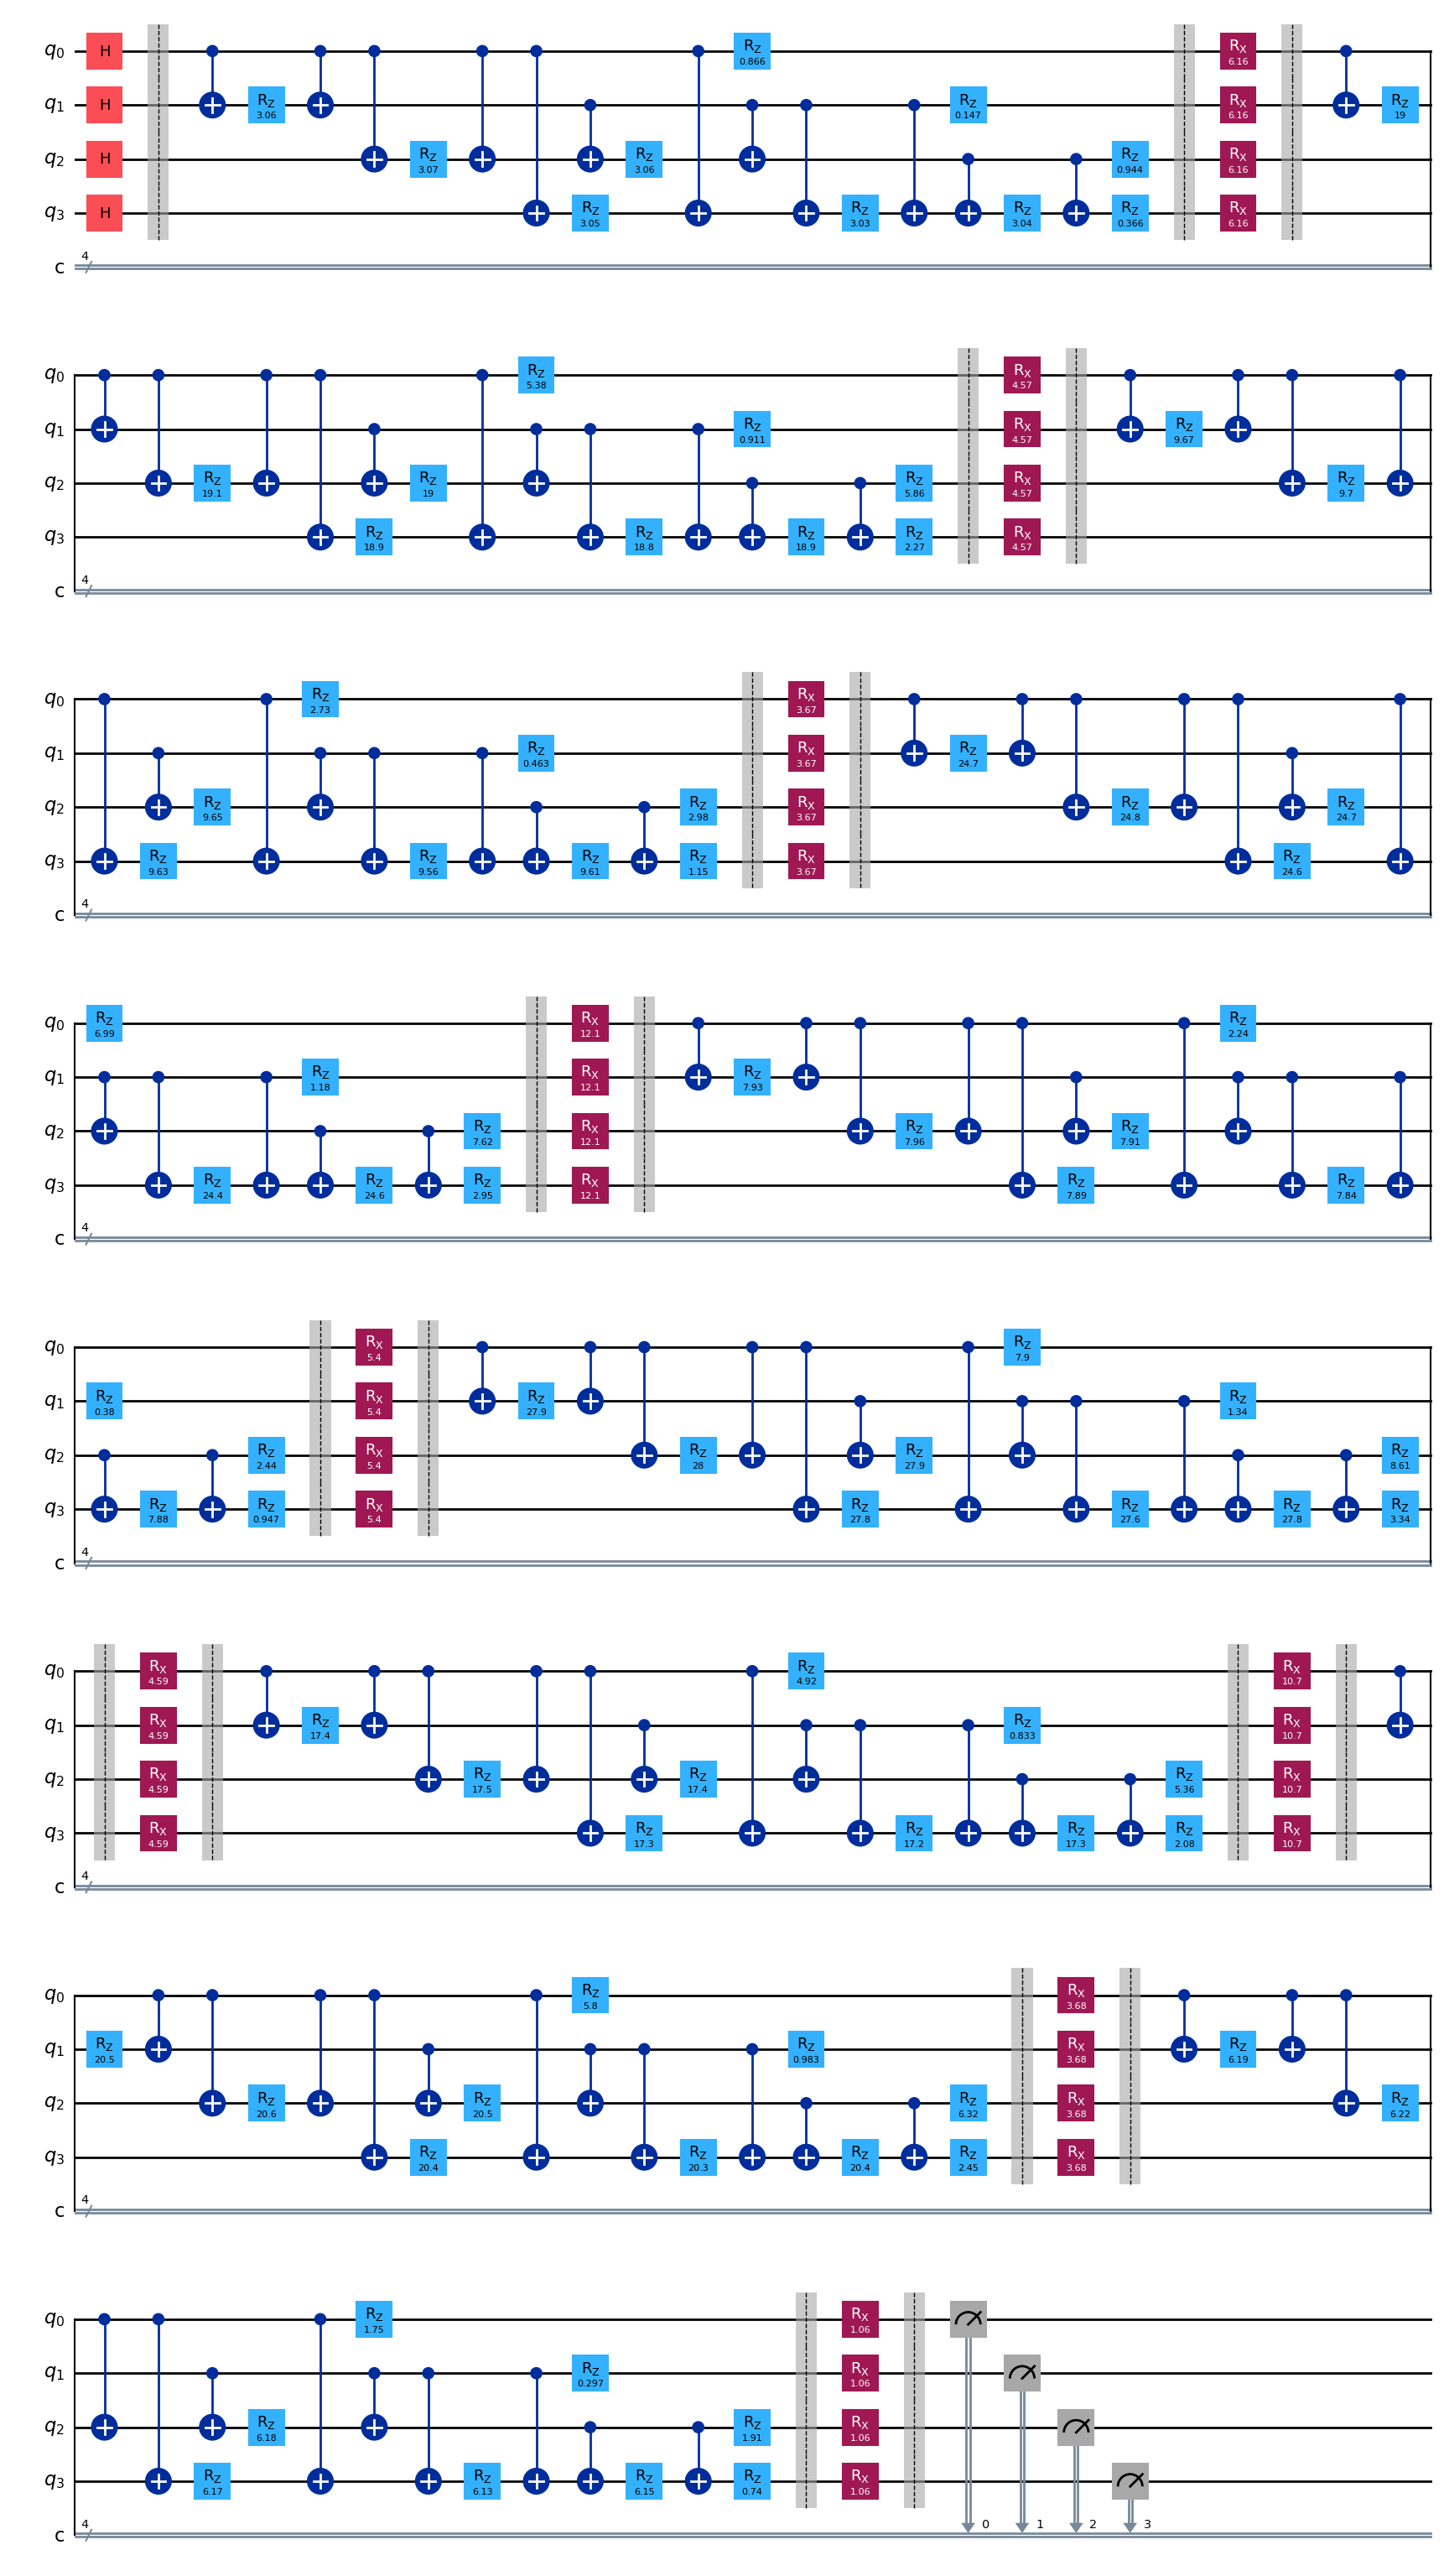

In [8]:
qaoa.draw()